<a href="https://colab.research.google.com/github/BalintVargaBME/Deep-Learning-a-gyarkolatban---BitMesterek/blob/main/BitMesterek_Optiver_Trading_at_the_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#VB
# Import libraries
import pandas as pd
import os
import zipfile
import numpy as np
import random
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
#VB
# Mount drive to colab
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#VB
# Navigate to working directory
# Change to your own Drive directory after MyDrive/

#%cd /content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi/

# Telling Kaggle where to find the API key, needed for dowloading dataset, change to your own directory after MyDrive/
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi"

In [ ]:
#VB
# Commented out so Colab won't download each time when all cells are run

# Download data from Kaggle
#!kaggle competitions download -c optiver-trading-at-the-close

In [ ]:
#VB

# Commented out so Colab won't download each time when all cells are run
# Unzip, then delete file


#for file in os.listdir():
 #   if file.endswith(".zip"):
  #      with zipfile.ZipFile(file, "r") as zip_file:
   #         zip_file.extractall()


# List files in working directory
%ls

sample_data/


In [ ]:
# Download train.csv
!wget https://www.dropbox.com/scl/fi/ibujwdcz78j7u2svlqmum/train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j&dl=0

--2023-11-27 10:25:15--  https://www.dropbox.com/scl/fi/ibujwdcz78j7u2svlqmum/train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc92ff944f352b652bbbb23eb7ff.dl.dropboxusercontent.com/cd/0/inline/CIXl13TsQ7VQon8263u1i3CGulw5M3mJC0IqIvzCJ7wmIQip61EvDDo6QWsdf1UJQwwesV1JhSbiU7XVrn5Uv5fHPl22pl69DfmTm2mBLsMIppFCCr57qpY3ON_vXIKsTyBuXq6WBaSWzuIIoRVTzy9s/file# [following]
--2023-11-27 10:25:16--  https://uc92ff944f352b652bbbb23eb7ff.dl.dropboxusercontent.com/cd/0/inline/CIXl13TsQ7VQon8263u1i3CGulw5M3mJC0IqIvzCJ7wmIQip61EvDDo6QWsdf1UJQwwesV1JhSbiU7XVrn5Uv5fHPl22pl69DfmTm2mBLsMIppFCCr57qpY3ON_vXIKsTyBuXq6WBaSWzuIIoRVTzy9s/file
Resolving uc92ff944f352b652bbbb23eb7ff.dl.dropboxusercontent.com (uc92ff944f352b652bbbb23eb7ff.dl.dropboxusercontent.com)... 162.125.64.15, 2620:100

In [ ]:
#VB
import_data = pd.read_csv ('train.csv?rlkey=r7rwxzxrawaavj8uyhb4edx6j')
import_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Number of datapoints:

200 stocks
481 days
55 steps each day

So number of datapoints should be 200 * 481 * 55  (stocks * days * steps) = 5291000

In [ ]:
#VB
import_data.shape

(5237980, 17)

We can see that 53020 datapoints are missing

In [ ]:
#VB
data_frame = import_data

# Group the data by 'date_id' and count the unique 'stock_id' values for each day
stock_count_per_day = data_frame.groupby('date_id')['stock_id'].nunique()

# Expected number of stocks each day
expected_stock_count = 200

# Number of missing stocks each day
missing_stock_count = expected_stock_count - stock_count_per_day

# Total missing stocks througouth the 200 days
total_missing_stocks = missing_stock_count.sum()

# Days and number of missing stocks
print("Date and number of missing stocks:")
print(missing_stock_count)

# Total number of missing stocks
print("Total number of missing stocks:", total_missing_stocks)


Date and number of missing stocks:
date_id
0      9
1      9
2      9
3      9
4      8
      ..
476    0
477    0
478    0
479    0
480    0
Name: stock_id, Length: 481, dtype: int64
Total number of missing stocks: 964


As we can see throughout the 481 days a total of 964 stocks are missing entirely. 964 * 55 = 53020,  so this means that missing data is found. This also means that fortunately that the stock data that we do have doesn't have any missing values.

In [ ]:
#VB
# Function to plot the time series of a stock on a day
def stock_plotter(data_frame, cols, stock_id, date_id):

  # Filtering data_frame where the stock_id and date_id match with our inputs
  data_frame = data_frame.query(f'stock_id == {stock_id} & date_id == {date_id}')

  # We want all rows of the seconds_in_bucket and input columns
  data_frame = data_frame.loc[:, ['seconds_in_bucket'] + cols]

  # Set seconds_in_bucket as the index for the data_frame
  data_frame = data_frame.set_index('seconds_in_bucket')

  # Plot time series
  data_frame = data_frame.plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)

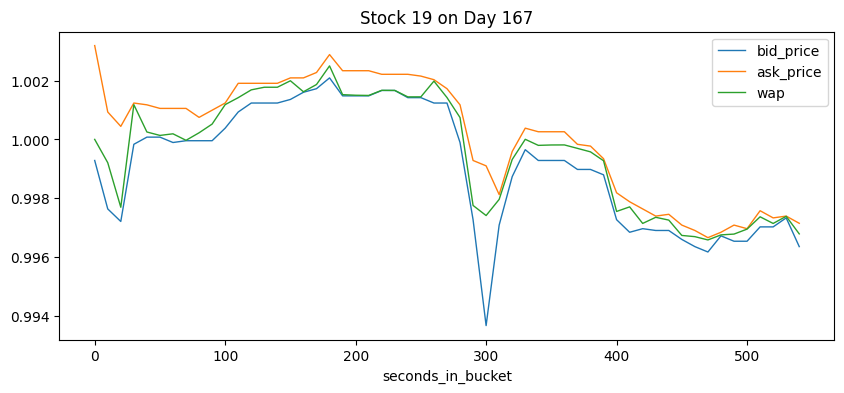

In [ ]:
#VB
# Generate random numbers to print random stocks on random days, not excluding the missing ones (will have to fix in future)
stock_no = random.randint(0,200)
day_no = random.randint(0,481)

# Plot
stock_plotter(
  data_frame=import_data,
  cols=['bid_price','ask_price', 'wap'],
  stock_id=stock_no,
  date_id=day_no)



In [ ]:
#VB

# Dropping NaN values because they cause errors in calculatin MAE
data_frame = data_frame.dropna(subset=['target'])

# Splitting data, dropping row_id becaues it's not necesseary, and it's 'object' type causing error with pandas
#X = data_frame.drop(['target', 'row_id'], axis=1)
#y = data_frame[['target']]


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,)


In [ ]:



#VB
# Storing hyperparameters and MAE score, will have better system for it in future
#model_params = []
#model_mae = []

In [ ]:
#VB
# Using LGBM framework for training model
#from lightgbm import LGBMRegressor
#params={'n_estimators': 300,
 #       'learning_rate': 0.09,
  #      'max_depth': 8,
   #     'num_leaves': 25,
    #    }

#model=LGBMRegressor(**params, random_state=123, device='cpu')
#model.fit(X_train, y_train)

In [ ]:
#VB
# Get predictions of test set
#pred_LGB=model.predict(X_test)

# Calculate the mean absolute error of the predictions and target
#mean_ae = mean_absolute_error(y_test,pred_LGB)
#print("MAE score of model =", mean_ae)

# Store hyperparameters and score
#model_params.append(model)
#model_mae.append(mean_ae)

In [ ]:
#VB
#print(model_params, model_mae)

In [ ]:

!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


In [ ]:

#There are a lot of Nan values in the dataset (especially in far_price, near_price), which causes problems with the training
print(data_frame.isnull().sum())


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64


In [ ]:
#delete the rows where these features are NaN (only 132 each which is not a big loss, considering that the number of all rows are 2894254)
data_frame = data_frame.dropna(subset=['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap'])

In [ ]:
#now far_price and near_price are the only features which have NaN values
#I am going to predict the missing values with Linear Regression (later can be improved)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data_frame_temp = data_frame.dropna(subset=['far_price', 'near_price'])

# Split the data into features (X) and target variable (y)
X_temp = data_frame_temp.drop(['far_price', 'near_price'], axis=1)
y_far = data_frame_temp[['far_price']]
y_near = data_frame_temp[['near_price']]

# Split the data into training and testing sets
X_far_train, X_far_test, y_far_train, y_far_test = train_test_split(X_temp, y_far, test_size=0.2, random_state=42)
X_near_train, X_near_test, y_near_train, y_near_test = train_test_split(X_temp, y_near, test_size=0.2, random_state=42)

# Train the Linear Regression model, later can be improved
model_far = LinearRegression()
model_far.fit(X_far_train, y_far_train)

model_near = LinearRegression()
model_near.fit(X_near_train, y_near_train)

# Make predictions
y_far_pred = model_far.predict(X_far_test)
y_near_pred = model_near.predict(X_near_test)

# Evaluate the model
mse_far = mean_squared_error(y_far_test, y_far_pred)
mse_near = mean_squared_error(y_near_test, y_near_pred)

print(f'Mean Squared Error (far_price): {mse_far}')
print(f'Mean Squared Error (near_price): {mse_near}')

Mean Squared Error (far_price): 0.7977772705070444
Mean Squared Error (near_price): 5.592018645611001e-05


In [ ]:
rows_with_missing_values_far = data_frame[data_frame['far_price'].isnull()]
rows_with_missing_values_near = data_frame[data_frame['near_price'].isnull()]

rows_with_missing_values_far = rows_with_missing_values_far.drop(['far_price', 'near_price'], axis=1)
rows_with_missing_values_near = rows_with_missing_values_near.drop(['far_price', 'near_price'], axis=1)

# Use the trained model to predict missing values
predicted_far_values = model_far.predict(rows_with_missing_values_far)
predicted_near_values = model_near.predict(rows_with_missing_values_near)

# Fill in the missing values in the original DataFrame
data_frame.loc[data_frame['far_price'].isnull(), 'far_price'] = predicted_far_values
data_frame.loc[data_frame['near_price'].isnull(), 'near_price'] = predicted_near_values

print(data_frame.isnull().sum())

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64


In [ ]:
# Splitting data, dropping row_id becaues it's not necesseary, and it's 'object' type causing error with pandas
X = data_frame.drop(['target', 'row_id'], axis=1)
y = data_frame[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband

#predicting with Hyperband

def build_model(hp):
    model_new = keras.Sequential()



     # Input layer
    model_new.add(layers.Flatten(input_shape=(X_train.shape[1],)))

    # Hidden layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=4, step=1)):
        model_new.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model_new.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model_new.add(layers.Dense(1, activation='linear'))


    model_new.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model_new


input_shape = X_train.shape[1]
output_classes = 1

tuner = Hyperband(
    build_model,
    max_epochs=10,
    factor=3,
    objective='val_mean_absolute_error',
    directory='tuning_directory',
    project_name='project'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 4 Complete [00h 11m 24s]
val_mean_absolute_error: 6.402994155883789

Best val_mean_absolute_error So Far: 6.402977466583252
Total elapsed time: 01h 28m 29s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3                 |4                 |num_layers
128               |352               |units_0
0.3               |0.4               |dropout_0
32                |480               |units_1
0.4               |0.1               |dropout_1
0.01              |0.001             |learning_rate
416               |32                |units_2
0.2               |0                 |dropout_2
384               |32                |units_3
0.2               |0                 |dropout_3
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 15631/117850 [==>...........................] - ETA: 4:42 

In [ ]:
best_model.fit(X_train, y_train)

# Get predictions of test set
pred_LGB=best_model.predict(X_test)

# Calculate the mean absolute error of the predictions and target
mean_ae = mean_absolute_error(y_test,pred_LGB)
print("MAE score of model =", mean_ae)